# Fully Convolutional Interior/Edge Segmentation for 2D Data

---

Classifies each pixel as either Cell Edge, Cell Interior, or Background.

There are 2 different Cell Edge classes (Cell-Cell Boundary and Cell-Background Boundary)

In [1]:
import os
import errno
import numpy as np
import deepcell

/usr/local/lib/python3.5/dist-packages/deepcell/utils/__init__.py:49: UserWarning: To use `compute_overlap`, the C extensions must be built using `python setup.py build_ext --inplace`
  warnings.warn('To use `compute_overlap`, the C extensions must be built '


### Load the training data

In [2]:
# create folder for this set of experiments
experiment_folder = "20191112_lab_combined"
MODEL_DIR = os.path.join("/data/models", experiment_folder)
NPZ_DIR = "/data/npz_data/"
LOG_DIR = '/data/logs'

if not os.path.isdir(MODEL_DIR):
    os.makedirs(MODEL_DIR)

In [18]:
npz_name = "lab_combined_train_128x128"
training_data = np.load(NPZ_DIR + npz_name +".npz")
(X_train, y_train) = training_data["X"], training_data["y"]

print('X_train.shape: {}\ny_train.shape: {}'.format(X_train.shape, y_train.shape))

X_train.shape: (1575, 128, 128, 3)
y_train.shape: (1575, 128, 128, 1)


### Set up filepath constants

In [4]:
# the path to the data file is currently required for `train_model_()` functions
DATA_FILE = os.path.join(NPZ_DIR, npz_name)

# confirm the data file is available
assert os.path.isfile(DATA_FILE)

### Set up training parameters

In [22]:
from tensorflow.keras.optimizers import SGD
from deepcell.utils.train_utils import rate_scheduler

conv_model_name = npz_name + '_convolutational_edge_512dense_128conv'

n_epoch = 10  # Number of training epochs
norm_method = 'std'  # data normalization
receptive_field = 61  # should be adjusted for the scale of the data

optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

lr_sched = rate_scheduler(lr=0.01, decay=0.99)
test_size = 0.05
seed=0

# FC training settings
n_skips = 3  # number of skip-connections (only for FC training)
batch_size = 1  # FC training uses 1 image per batch

# Transformation settings
transform = 'pixelwise'
dilation_radius = 1  # change dilation radius for edge dilation
separate_edge_classes = False  # break edges into cell-background edge, cell-cell edge
n_features = 4 if separate_edge_classes else 3

### Create a model for the edge/interior segmentation

#### Instantiate the segmentation transform model

In [6]:
from deepcell import model_zoo

conv_model = model_zoo.bn_feature_net_skip_2D(
    fgbg_model=None,
    receptive_field=receptive_field,
    n_skips=n_skips,
    n_features=n_features,
    norm_method=norm_method,
    n_conv_filters=128,
    n_dense_filters=512,
    last_only=False,
    input_shape=tuple(X_train.shape[1:]))

#### Train the segmentation transform model

In [24]:
from deepcell.training import train_model_conv

conv_model = train_model_conv(
    model=conv_model,
    dataset=DATA_FILE,  # full path to npz file
    model_name=conv_model_name,
    test_size=test_size,
    seed=seed,
    transform=transform,
    dilation_radius=dilation_radius,
    separate_edge_classes=separate_edge_classes,
    optimizer=optimizer,
    batch_size=batch_size,
    n_epoch=n_epoch,
    log_dir=LOG_DIR,
    model_dir=MODEL_DIR,
    lr_sched=lr_sched,
    rotation_range=180,
    flip=True,
    shear=False,
    zoom_range=(0.8, 1.2),)

X_train shape: (1496, 128, 128, 3)
y_train shape: (1496, 128, 128, 1)
X_test shape: (79, 128, 128, 3)
y_test shape: (79, 128, 128, 1)
Output Shape: (None, 128, 128, 3)
Number of Classes: 3
Training on 1 GPUs
Epoch 1/10
1495/1496 [============================>.] - ETA: 0s - loss: 2.3160 - model_loss: 0.5511 - model_1_loss: 0.5384 - model_2_loss: 0.5431 - model_3_loss: 0.5387 - model_acc: 0.7975 - model_1_acc: 0.8016 - model_2_acc: 0.8010 - model_3_acc: 0.8023
Epoch 00001: val_loss improved from inf to 1.91090, saving model to /data/models/20191112_lab_combined/lab_combined_train_128x128_convolutational_edge_512dense_128conv.h5
1496/1496 [==============================] - 361s 241ms/step - loss: 2.3155 - model_loss: 0.5510 - model_1_loss: 0.5383 - model_2_loss: 0.5430 - model_3_loss: 0.5385 - model_acc: 0.7975 - model_1_acc: 0.8017 - model_2_acc: 0.8011 - model_3_acc: 0.8023 - val_loss: 1.9109 - val_model_loss: 0.4348 - val_model_1_loss: 0.4401 - val_model_2_loss: 0.4562 - val_model_3_lo

### Run the model

#### Make predictions on test data

In [25]:
test_data = np.load(NPZ_DIR + "lab_combined_test.npz")
(X_test, y_test) = test_data["X"], test_data["y"]

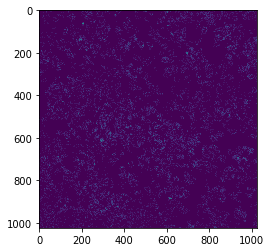

In [28]:
plt.imshow(X_test[0, :, :, 2])

In [29]:
weights_path = "/data/models/20191112_lab_combined/lab_combined_train_128x128_convolutational_edge_512dense_128conv.h5"
run_conv_model = model_zoo.bn_feature_net_skip_2D(
    fgbg_model=None,
    receptive_field=receptive_field,
    n_skips=n_skips,
    n_features=n_features,
    norm_method=norm_method,
    n_conv_filters=128,
    n_dense_filters=512,
    last_only=False,
    input_shape=tuple(X_test.shape[1:]))

run_conv_model.load_weights(weights_path)

In [33]:
test_images_conv = run_conv_model.predict(X_test[0:1, :, :, :])[-1]
#test_images_fgbg = fgbg_model.predict(X_test)[-1]

#print('watershed transform shape:', test_images.shape)
#print('segmentation mask shape:', test_images_fgbg.shape)

NameError: name 'test_images' is not defined

#### Post-processing

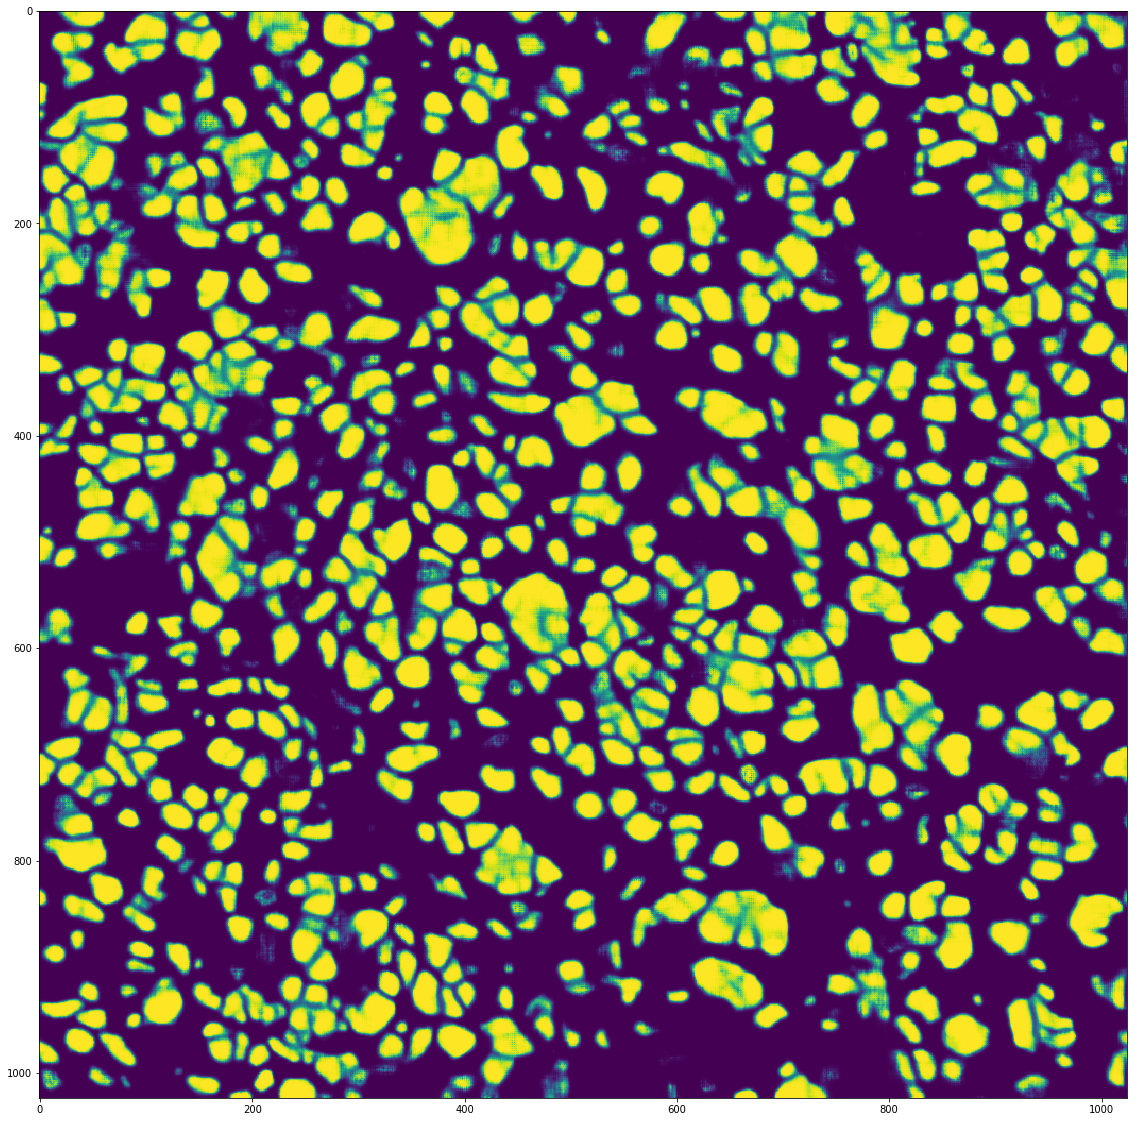

In [34]:
import matplotlib.pyplot as plt
plt.figure(figsize = (20, 20))
plt.imshow(test_images_sample[0, :, :, 1])

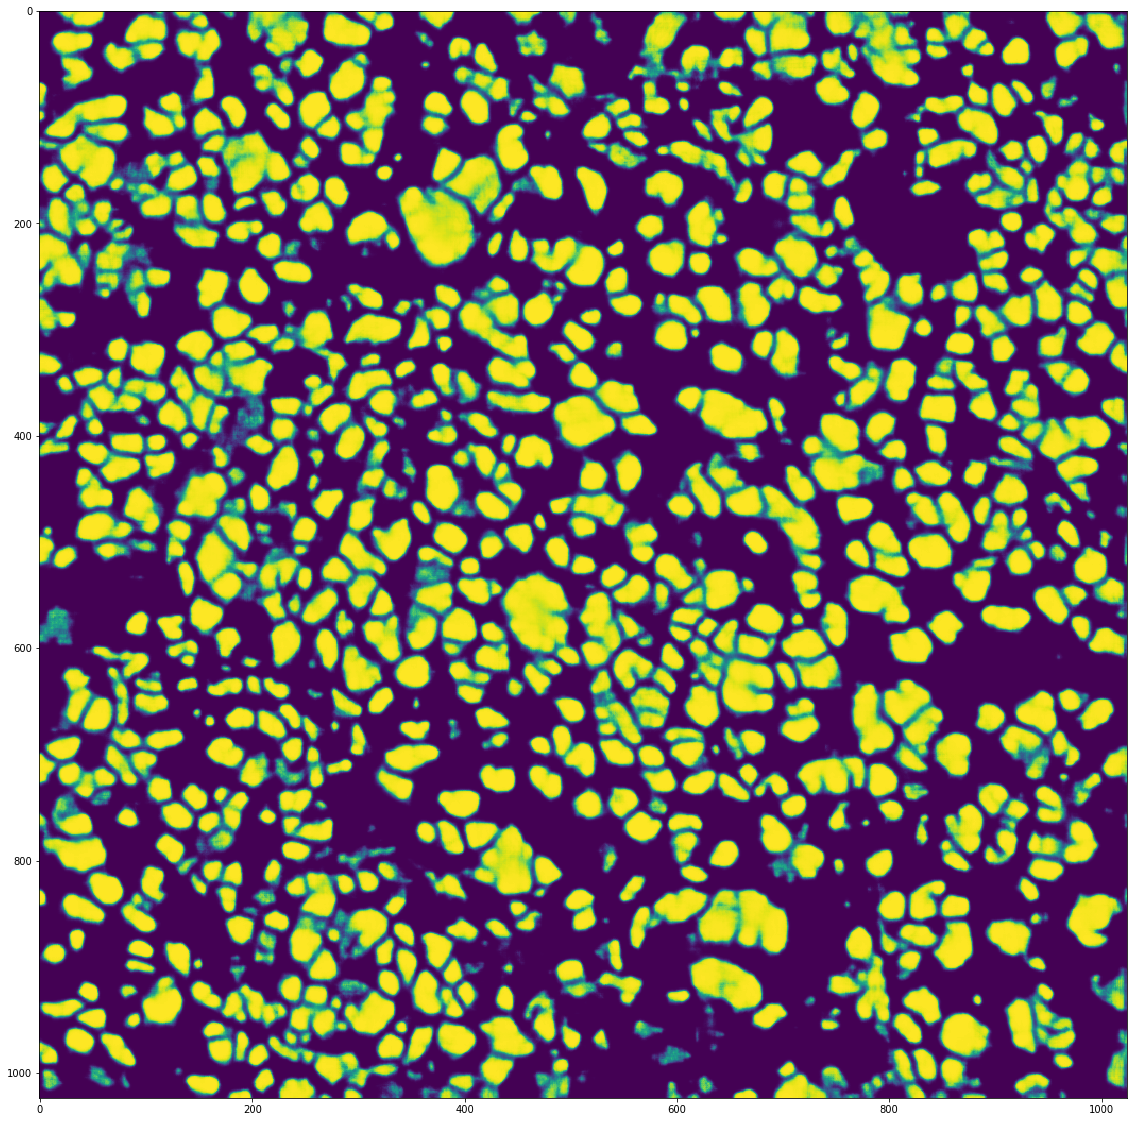

In [36]:
import matplotlib.pyplot as plt
plt.figure(figsize = (20, 20))
plt.imshow(test_images_conv[0, :, :, 1])